# MLB Swing Classification
**Author**: Eric Wehmueller
***

## Overview

This project is the final/Capstone project for Flatiron School's bootcamp program in Data Science.  We have created a hypothetical situation as a Data Scientist and are hoping to provide value to our business for the scenario.

## Business Problem

A hot topic in the 2021 Major League Baseball season surrounds discussion about certain substances being used by pitchers to increase their "spin rate"- an advanced metric now being recorded on every pitch by sophisticated cameras.  The argument is that a higher spin rate on pitches gives better results, and this substance is legal and used by a high percentage of pitchers around the league.  However, this is not the singular determining factor in throwing an effective pitch: namely, one that will cause a Major League better to swing and miss. Although typically regarded as an "old man's game", can we get a step ahead of the game and leverage this metric and a variety of other data on pitches to know what types of pitches will give us the best results?  

We have been hired as a hypothetical member of the Cardinals baseball organization: a member of the coaching staff.  As a coaching analyst, our job is to create a model that will give us insights into pitch quality and classify a pitch, given its metrics, as a "strike" or a red flag "hit" for our opponent.

## Project Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tensorflow/keras libraries
import keras
import tensorflow as tf
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz, plot_tree
from IPython.display import Image
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

In [3]:
from pybaseball import playerid_lookup, statcast_batter, statcast_pitcher

## Data Exploration

To start, let's see if we can get some immediate value in our current season against one particular player giving us trouble. So far in the 2021 season, Jesse Winker, a member of the Cincinnati Reds, has proven himself as an elite hitter.  Since we are in the same division as this team (NL Central), he is going to be in the batters' box against our pitchers extremely often.  If we can find a way to mitigate the damage he does against our ball club, that would be ideal. Let's work towards creating a model specifically for this.

In [4]:
player_info_df = playerid_lookup('winker','jesse')
player_info_df.head()

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,winker,jesse,608385,winkj002,winkeje01,13590,2017.0,2021.0


In [5]:
jwinker_id = 608385
#statcast data (data per pitch, goes back to 2015)
df = statcast_batter('2016-08-01','2021-08-01', jwinker_id)

Gathering Player Data


In [6]:
df.shape

(5805, 92)

In [7]:
print(df.columns.tolist())

['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 

In [8]:
pd.set_option('max_columns', 100)
pd.set_option('display.max_colwidth', None)
df.head(5)

#todo- visualizations

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.0,204.5,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.708
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038


Needs Exact Clarification:
***

pfx_x, pfx_z

plate_x, plate_z

vx0, vy0, vz0

ax, ay, az

sz_top, sz_bot

spin_axis

zone


***
***
Other potentially relevant features for our model:
***
pitch_type/pitch_name, pitch_number

release_speed

release_pos_x, release_pos_z

events, description

stand, p_throws

balls, strikes

release_spin_rate, release_extension

***

Documentation on the specifics of these metrics can be found at https://baseballsavant.mlb.com/csv-docs







In [9]:
#looking to remove "intent_ball", this is not a pitch that has the intention
#of making the hitter swing, so we could remove these
df['description'].unique().tolist()

['hit_into_play',
 'foul',
 'ball',
 'swinging_strike',
 'called_strike',
 'foul_tip',
 'blocked_ball',
 'swinging_strike_blocked',
 'hit_by_pitch',
 'foul_bunt',
 'missed_bunt']

From this list, we could make our target column for classification purposes. Namely, 1 for a swing and 0 for a non-swing to keep it simple.  We could make this more sophisticated later if need be.. For example- can we get ahead in the count by forcing foul balls? Or maybe "hit_into_play" is not always bad- forcing an easy infield ground ball is also an easy way to get a batter out)

In [10]:
df['pitch_type'].unique().tolist()

['FS', 'FC', 'SL', 'SI', 'FF', 'CU', 'CH', 'KC', 'FT', nan, 'FO', 'KN']

In [11]:
#checking for nulls in pitch location/speed data, this is important
print(df['pitch_type'].isna().sum())
print(df['release_speed'].isna().sum())
print(df['plate_x'].isna().sum())
print(df['plate_z'].isna().sum())

51
48
49
49


In [12]:
df2 = df.loc[(df['pitch_type'].notnull()) & (df['release_speed'].notnull())
            & (df['plate_x'].notnull()) & (df['plate_z'].notnull())]
print(df2.shape)
df2.head()

(5754, 92)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.0,204.5,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.708
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038


Additionally, I am going to attempt to classify events as favorable or unfavorable for the pitcher, denoted by 1, 0, or -1.

I'll engineer a field "swing_for_stk_or_out" to denonte the difference between a swing, which could have a wide variety of outcomes (home run vs a called strike, for example). I'll only count swings that register a strike or an out as a 1 in this field, balls as a zero, and very negative pitcher outcomes as -1 (hits, walks, and sac flies). We'll have to look at both the 'description' column as well as the 'events' column to achieve this.

In [13]:
df2['swing_stk_or_out'] = 0

<ipython-input-13-ad41a3d6c6ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['swing_stk_or_out'] = 0


In [14]:
df2['events'].unique().tolist()

['double',
 nan,
 'strikeout',
 'field_out',
 'walk',
 'single',
 'home_run',
 'grounded_into_double_play',
 'fielders_choice',
 'field_error',
 'force_out',
 'hit_by_pitch',
 'fielders_choice_out',
 'triple',
 'sac_fly',
 'caught_stealing_2b',
 'strikeout_double_play',
 'sac_bunt']

In [15]:
#

In [16]:
df2.loc[df2['description'].isin(['hit_into_play', 'foul', 'swinging_strike',
 'called_strike', 'foul_tip', 'swinging_strike_blocked', 'foul_bunt',
 'missed_bunt']), 'swing_stk_or_out'] = 1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [17]:
df2.loc[df2['events'].isin(['double', 'walk', 'single',
 'home_run', 'triple', 'sac_fly']), 'swing_stk_or_out'] = -1

In [18]:
df2.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,swing_stk_or_out
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.00,204.50,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.708,-1
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000,1
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056,1
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028,0
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038,1
5,FF,2021-08-01,93.1,-1.22,5.34,"Winker, Jesse",608385,573186,strikeout,swinging_strike,NaN,NaN,NaN,NaN,12.0,Jesse Winker strikes out swinging.,R,L,R,NYM,CIN,S,2.

In [19]:
df2['pitch_type'].unique().tolist()

['FS', 'FC', 'SL', 'SI', 'FF', 'CU', 'CH', 'KC', 'FT', 'FO', 'KN']

I'm going to simplify this into 2 types of pitches- fastball or offspeed for our model.

In [20]:
fastballs = ['FC', 'SI', 'FF','FT']
offspeeds = ['FS', 'SL', 'CU', 'CH', 'KC', 'FO', 'KN']

In [21]:
df2['is_fastball'] = 0

<ipython-input-21-516ffa13e6da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['is_fastball'] = 0


In [22]:
df2.loc[df2['pitch_type'].isin(fastballs), 'is_fastball'] = 1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [23]:
df2.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,swing_stk_or_out,is_fastball
0,FS,2021-08-01,86.5,-1.24,5.28,"Winker, Jesse",608385,573186,double,hit_into_play,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,X,4.0,ground_ball,1,2,2021,-0.94,-0.10,0.28,0.64,NaN,NaN,NaN,0,6,Top,126.0,204.5,NaN,NaN,621512,NaN,NaN,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,3.49,1.60,72.0,85.4,4.0,85.9,1767.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.91,0.363,0.35,1.25,1.0,1.0,1.0,2.0,37,5,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,242.0,-0.068,0.708,-1,0
1,FS,2021-08-01,88.3,-1.22,5.26,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,8.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,2,2021,-0.69,-0.51,-0.15,1.84,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,3.49,1.60,NaN,NaN,NaN,87.4,1902.0,5.6,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,4,Split-Finger,0,1,1,0,1,0,1,0,Infield shift,Standard,243.0,0.000,0.000,1,0
2,FC,2021-08-01,90.4,-1.37,5.24,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,2.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,1,1,2021,0.23,0.85,0.06,3.21,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,3.49,1.60,219.0,73.4,28.0,90.2,2743.0,5.8,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,3,Cutter,0,1,1,0,1,0,1,0,Infield shift,Standard,213.0,0.000,-0.056,1,1
3,SL,2021-08-01,86.2,-1.27,5.27,"Winker, Jesse",608385,573186,NaN,ball,NaN,NaN,NaN,NaN,14.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,B,NaN,NaN,0,1,2021,0.94,0.16,1.97,-0.32,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,3.32,1.52,NaN,NaN,NaN,86.0,2937.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,2,Slider,0,1,1,0,1,0,1,0,Infield shift,Standard,49.0,0.000,0.028,0,0
4,SI,2021-08-01,91.2,-1.23,5.29,"Winker, Jesse",608385,573186,NaN,foul,NaN,NaN,NaN,NaN,4.0,Jesse Winker doubles (27) on a ground ball to second baseman Jeff McNeil.,R,L,R,NYM,CIN,S,NaN,NaN,0,0,2021,-0.96,0.18,-0.64,2.45,NaN,NaN,NaN,0,6,Top,NaN,NaN,NaN,NaN,621512,NaN,NaN,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,3.49,1.60,228.0,76.4,45.0,91.7,2482.0,5.9,633129,573186,621512,624413,643446,592273,595879,642086,607680,624424,54.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,1,Sinker,0,1,1,0,1,0,1,0,Infield shift,Standard,218.0,0.000,-0.038,1,1


In [24]:
df2['is_pitcher_righty'] = 0

<ipython-input-24-7ac8acdb1d98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['is_pitcher_righty'] = 0


In [25]:
df2.loc[df2['p_throws'] == 'R', 'is_pitcher_righty'] = 1

C:\Users\Darko\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [26]:
model_df = df2[['is_fastball','is_pitcher_righty','release_speed',
                  'plate_x','plate_z','pfx_x','pfx_z','vx0','vy0','vz0',
                  'ax','ay','az','release_spin_rate',
                  'strikes','balls','swing_stk_or_out']]
model_df.head(50)

,is_fastball,is_pitcher_righty,release_speed,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,strikes,balls,swing_stk_or_out
0,0,1,86.5,0.28,0.64,-0.94,-0.10,5.470293,-125.956504,-4.687578,-11.032610,22.430124,-32.573620,1767.0,2,1,-1
1,0,1,88.3,-0.15,1.84,-0.69,-0.51,3.988880,-128.595114,-1.212061,-8.478128,25.878591,-37.828954,1902.0,2,1,1
2,1,1,90.4,0.06,3.21,0.23,0.85,3.061059,-131.745523,-1.004938,2.110204,24.609554,-22.198202,2743.0,1,1,1
3,0,1,86.2,1.97,-0.32,0.94,0.16,5.749211,-125.440565,-7.388813,9.023742,22.363264,-29.337223,2937.0,1,0,0
4,1,1,91.2,-0.64,2.45,-0.96,0.18,3.502166,-133.082664,-1.781584,-12.223426,21.352922,-29.919013,2482.0,0,0,1
5,1,1,93.1,0.00,3.79,-0.33,1.03,3.822021,-135.744296,-0.561437,-4.826120,25.275468,-19.386844,2487.0,2,2,1
6,0,1,84.9,-0.03,2.78,1.14,0.32,0.956030,-123.955315,-0.433315,11.837550,18.606104,-28.952408,2539.0,1,2,1
7,0,1,84.6,-0.20,2.92,0.80,0.23,1.381606,-123.385997,0.390213,8.063831,21.376316,-30.046890,2669.0,0,2,1
8,1,1,92.8,-1.27,1.74,-0.66,0.25,1.410019,-135.244894,-3.871757,-8.459930,26.329627,-28.519733,2285.0,0,1,0
9,0,1,88.4,-1.40,1.20,-1.07,-0.05,2.012130,-128.798705,-3.800888,-12.401942,23.992851,-32.268301,1564.0,0,0,0


In [27]:
model_df = model_df.iloc[::-1]

In [28]:
model_df.head(30)

,is_fastball,is_pitcher_righty,release_speed,plate_x,plate_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,strikes,balls,swing_stk_or_out
5804,0,1,82.8,0.01,2.80,-1.00,0.51,-0.499430,-120.550634,-2.599534,-9.678987,21.891396,-26.951538,851.0,0,0,1
5803,1,1,92.1,-0.22,1.46,-1.07,1.51,1.261450,-133.740565,-9.393077,-13.286912,27.793748,-12.100016,2092.0,1,0,1
5802,0,1,82.2,-1.11,0.74,-0.80,0.53,-2.965618,-119.385510,-7.071416,-7.084143,23.466330,-25.879091,782.0,2,0,0
5801,0,1,81.6,-0.99,0.89,-1.06,0.48,-2.518183,-118.542927,-6.689493,-9.596888,22.866890,-26.551975,774.0,2,1,1
5800,1,1,93.0,0.22,2.01,0.09,1.62,6.900506,-134.958910,-6.211075,-0.326430,27.123717,-11.361783,2275.0,0,0,-1
5799,1,1,93.9,-0.62,3.41,-0.95,1.74,7.535492,-135.851034,-4.300729,-13.390597,34.955486,-10.447934,2429.0,0,0,-1
5798,1,1,91.1,-0.07,3.25,-0.98,1.59,3.158312,-132.160425,-4.500311,-11.839880,29.046797,-13.388146,2172.0,0,0,1
5797,0,1,76.1,0.91,2.49,1.06,-0.85,5.309346,-110.416138,1.400994,7.362015,21.794727,-39.498229,2666.0,0,0,1
5796,0,1,85.7,-0.43,3.28,-1.59,0.47,8.582171,-124.345429,-0.315679,-18.332180,24.865167,-27.417586,1858.0,1,0,1
5795,0,1,86.7,-0.71,0.55,-1.84,0.29,8.595478,-125.778843,-6.559372,-21.443224,25.258661,-27.897009,1859.0,2,0,1


In [29]:
#checking for nulls/nans again here before modeling phase
model_df.isnull().sum(axis = 0)

is_fastball           0
is_pitcher_righty     0
release_speed         0
plate_x               0
plate_z               0
pfx_x                 0
pfx_z                 0
vx0                   0
vy0                   0
vz0                   0
ax                    0
ay                    0
az                    0
release_spin_rate    61
strikes               0
balls                 0
swing_stk_or_out      0
dtype: int64

In [30]:
print(model_df.shape)
model_df = model_df.dropna()
print(model_df.shape)

model_df.isnull().sum(axis = 0)

(5754, 17)
(5693, 17)


is_fastball          0
is_pitcher_righty    0
release_speed        0
plate_x              0
plate_z              0
pfx_x                0
pfx_z                0
vx0                  0
vy0                  0
vz0                  0
ax                   0
ay                   0
az                   0
release_spin_rate    0
strikes              0
balls                0
swing_stk_or_out     0
dtype: int64

Let's take a look at which features correlate the most to our target outcome ('swing_stk_or_out').

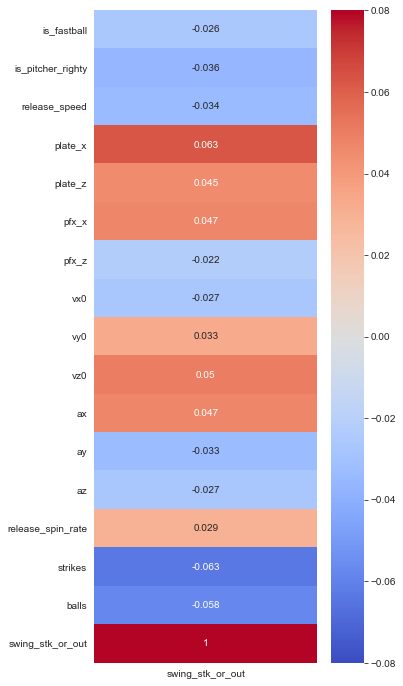

In [31]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(5, 12))
sns.heatmap(model_df.corr()[['swing_stk_or_out']], annot=True, 
            cmap="coolwarm", vmin=-0.08, vmax=0.08);

This is interesting to see, but I'm not sure how interpretable this is for some features. For example, increasingly negative values for 'pfx_x' indicate more movement from Right to Left, whereas higher positive values indicate more movement from Left to Right. We should probably be taking the absolute value of this field for being able to comment on Jesse Winker's ability to handle general horizonal movement, but losing information on the direction of the movement is not ideal here.

However, it is worth noting that higher "plate_x" and "plate_z" values tends towards positive pitcher outcomes, meaning that pitches up and/or inside (relative to our left-handed hitter Jesse Winker) more often result in a positive outcome for our pitcher.

Additionally, there is somewhat of a correlation between the handedness of the pitcher and the outcome.  This indicates that lower values for "is_pitcher_righty" typically result in positive outcomes for our pitcher. In other words, left handed pitchers seem to have a better time against Jesse, who is also a left handed hitter.  This is reassuring, as it is a commonly held belief that handedness mismatches tend to favor the batter. The data here confirms there is some value in this sentiment. This is why some players opt to switch-hit; even though they might be weaker on one side, they believe this handedness mismatch to be a more important determining factor in their success.

Additionally, there seems to also be a strong correlation between the number of balls or strikes and the outcome.  This seems to indicate that Jesse may start to catch on to the pitch sequence during the at-bat, or be able to more easily predict the next pitch as an at-bat drags on.  The best chance for success for our pitchers is to get him to guess early, as to not "show our hand" so to speak.


## Basic Model

In [32]:
X1= model_df.drop('swing_stk_or_out', 1)
y1= model_df['swing_stk_or_out']

X_train, X_test, y_train, y_test = train_test_split(
    X1,
    y1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4269, 16), (1424, 16), (4269,), (1424,))

In [33]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [34]:
y_pred_train = nb.predict(X_train)
y_pred_test = nb.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.25      0.27      0.26       128
           0       0.82      0.74      0.77       536
           1       0.75      0.80      0.78       760

    accuracy                           0.73      1424
   macro avg       0.61      0.60      0.60      1424
weighted avg       0.73      0.73      0.73      1424



In [36]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          -1       0.28      0.34      0.31       399
           0       0.83      0.74      0.78      1556
           1       0.77      0.80      0.78      2314

    accuracy                           0.73      4269
   macro avg       0.62      0.62      0.62      4269
weighted avg       0.74      0.73      0.74      4269



In [ ]:
nb.featur

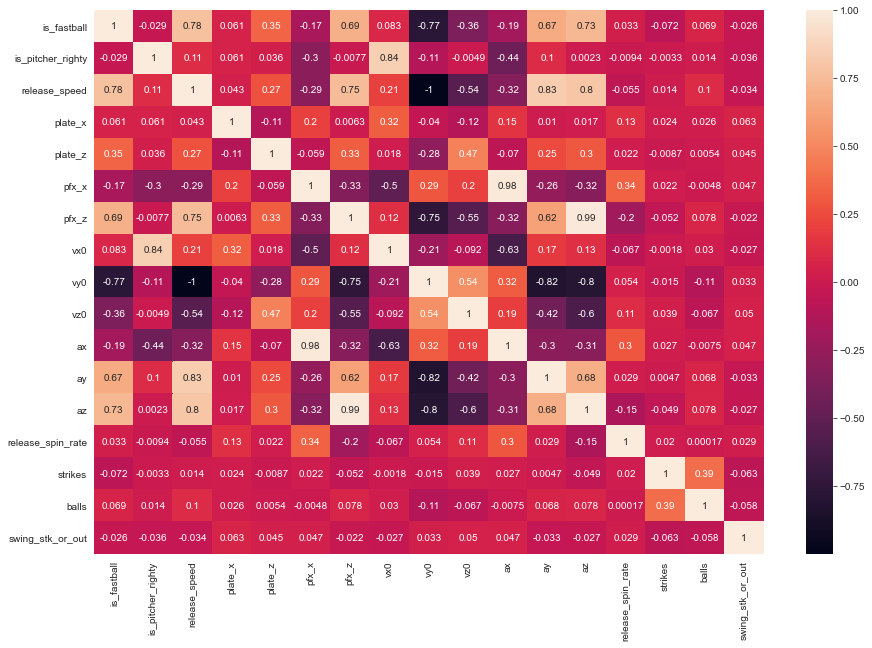

In [37]:
corr = model_df.corr()
plt.figure(figsize=(15,10))
ax= plt.subplot()
sns.heatmap(corr, ax=ax, annot=True);

From this heatmap, I've gathered some useful information for our models moving forward.  Firstly, "release_speed" is the same as "vy0", just in a different metric.  Additionally, the acceleration fields ("ax", "ay", and "az" fields) are also highly correlated with the velocity fields.  For this reason, I will be removing the acceleration fields from our model. Aside from this, the only other fields with high correlation with one another is the "is_fastball" and "vy0", namely the velocity, which totally makes sense. But I'll keep this for now as the value does not exceed 0.8 in either direction.

In [38]:
model_df = model_df.drop(['ax','ay','az','release_speed'], axis=1)

In [39]:
X_train = X_train.drop(['ax','ay','az','release_speed'], axis=1)

In [40]:
X_test = X_test.drop(['ax','ay','az','release_speed'], axis=1)

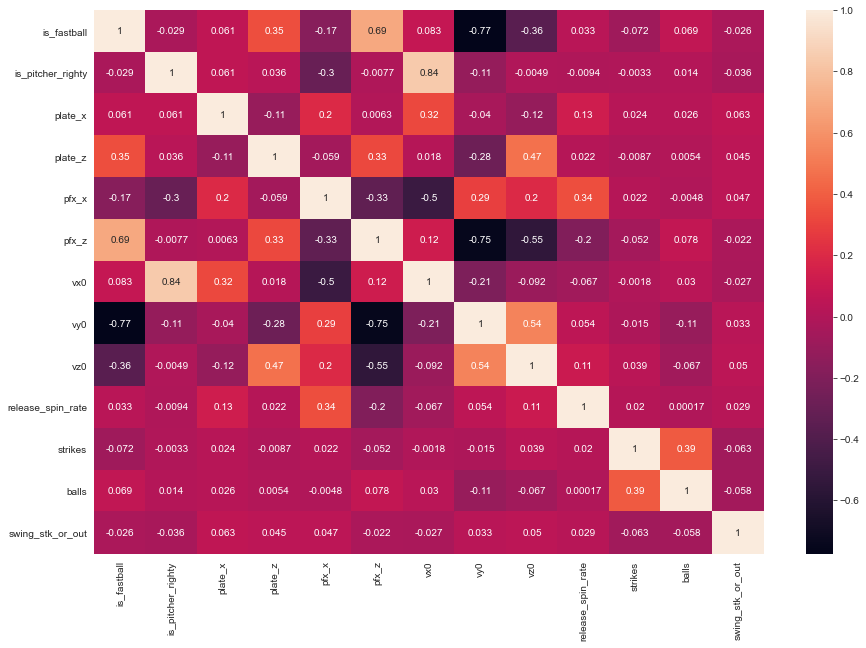

In [41]:
corr = model_df.corr()
plt.figure(figsize=(15,10))
ax= plt.subplot()
sns.heatmap(corr, ax=ax, annot=True);

In [60]:
# y_score = nb.decision_function(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_score)


# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
# ax1.plot(fpr, tpr, color=BLUE, label='ROC Curve')
# ax1.plot([0,1], [0,1], color='red', ls=':') # Creating a diagonal line.
# ax1.set(
#     title='ROC Curve',
#     xlabel='False Positive Rate',
#     ylabel='True Positive Rate'
# )


AttributeError: 'GaussianNB' object has no attribute 'decision_function'

## Model Iteration

I'm going to try a different approach now that we've removed some redundant features.


In [42]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
scores = cross_val_score(model_xgb, X_train,y_train)
print('cross-val-scores')
print(scores)
print('mean')
print(round(scores.mean(), 5))

cross-val-scores
[0.79742389 0.81967213 0.79742389 0.79274005 0.81828839]
mean
0.80511


In [43]:
pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

          -1       0.60      0.20      0.30       128
           0       0.83      0.84      0.83       536
           1       0.78      0.86      0.82       760

    accuracy                           0.80      1424
   macro avg       0.74      0.64      0.65      1424
weighted avg       0.78      0.80      0.78      1424



In [44]:
pred_xgb = model_xgb.predict(X_train)
print(classification_report(y_train, pred_xgb))

              precision    recall  f1-score   support

          -1       1.00      0.98      0.99       399
           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00      2314

    accuracy                           1.00      4269
   macro avg       1.00      0.99      1.00      4269
weighted avg       1.00      1.00      1.00      4269



In [ ]:
#todo- confusion matrix
conf_mx = confusion_matrix(y_binary, y_pred)
conf_mx

In [61]:
#todo- ROC curve

In [58]:
#y_score = model_xgb.predict_proba(X_test)[:,1]

ValueError: multiclass format is not supported

In [ ]:
#todo- addressing class imbalance, addressing our 0.20 recall and 0.30 f1-score?????

Definitely concerned that we are overfitting here with our use of XGBoost.

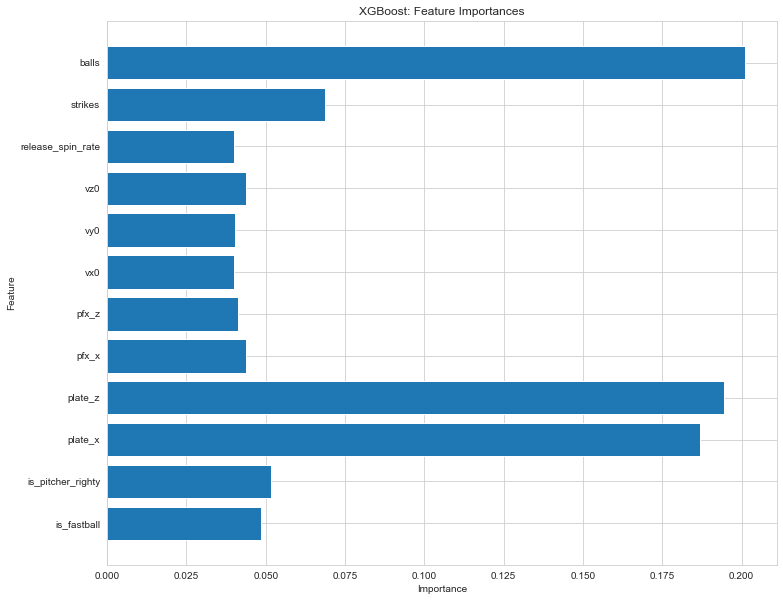

In [47]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
barlist = plt.barh(y=X_train.columns, width=model_xgb.feature_importances_)
ax.set(
    title="XGBoost: Feature Importances",
    ylabel="Feature",
    xlabel="Importance"
);

## Machine Learning Model??

In [ ]:
model_cnn = Sequential()
#model_cnn.add
